In [ ]:
#Modules to make the code run

from shapely.geometry import Point, Polygon
from multiprocessing import  Pool
import pandas as pd
import numpy as np
import os
import geopandas as gpd

import folium
from folium.plugins import HeatMap
import shapely.wkt

import matplotlib.pyplot as plt
from geopandas import GeoDataFrame, GeoSeries
import datetime
import branca
from keplergl import KeplerGl



### Uber Datasets (CREATE ONE DATASET)

We explore the uber datasets provided in 2014 and 2015, they do not share the same structure. The 2014 dataset has information about coordinates, meanwhile the 2015 dataset provide the pickup_id location. Based on this fact and using the 'zones.csv' dataset we decided to group both datasets using the 'NTA CODE', and preserved the pick_up date which both files share:

- In order to make this conversion we also explore the geographic.csv, which contains the borders of New York's NTA (Neighborhood Tabulation Areas), this dataset is incomplete. We replace it with 'nynta.csv', a dataset from NYC Open Data that contains the full information needed. 
- Defining a function to apply the geographic info to uber 2014 dataset, parallizing it we create a new uber 2014 dataset containing the nta code.
- After creating the new dataset we take the common columns between 2014 and 2015 to create 1 big dataset.


In [ ]:
#Reading geographic info, init the coordinate reference system and reading the zones dataset, which join the pickup location id with NTA.
nyc_zones = pd.read_csv('data/nynta.csv').set_index('NTACode')
nyc_zones['the_geom'] = nyc_zones['the_geom'].apply(lambda x: shapely.wkt.loads(x))
gps = gpd.GeoDataFrame(nyc_zones, geometry=nyc_zones['the_geom'])
gps.crs = {'init': 'epsg:4326'}
zones = pd.read_csv('data/zones.csv')

In [ ]:
#Create a function to return zones using the geographic 
def getZone(longitude, latitude, zones=gps['the_geom'].to_dict()):
    for zone in zones:
        if Point(longitude,latitude).within(zones[zone]):
            return zone

In [ ]:
#Parallizing the function to let python use multiple cores for fast proccessing.
def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def apply_zone(df):
    return df.apply(lambda row: getZone(row['pickup_longitude'], row['pickup_latitude']), axis = 1)

In [ ]:
#This code will use a lot of RAM, use only if you want to redo the 2014 dataset
uber_trips_2014 = pd.read_csv('data/uber_trips_2014.csv') #Reading the 2014 uber dataset
uber_trips_2014 = uber_trips_2014[['pickup_datetime','pickup_latitude','pickup_longitude']]
uber_trips_2014['nta_code'] = parallelize_dataframe(uber_trips_2014, apply_zone)
#After run the snippet of code you can use pd.to_csv('data/uberTrips2014_zones.csv') to save the dataset as csv.

#### Merging ALL Into 1 dataset

One last step to ensure data consistency with date format in both files. (This snippet take a lot of RAM, run only if you need to redo this file) 

In [ ]:
uber_trips_2014 = pd.read_csv('data/uberTrips2014_zones.csv')
uber_trips_2015 = pd.read_csv('data/uber_trips_2015.csv')
uber_trips_2015.drop(['dispatch_base','affiliate_base'], axis=1, inplace=True) # dropping base info we don't need. 
# finding the nta_code in 2015
uber_trips_2015 = uber_trips_2015.merge(zones, left_on = 'pickup_location_id', right_on = 'location_id')[['pickup_datetime', 'nta_code']]
# ensuring the datetime consistency.
uber_trips_2015['pickup_datetime'] = pd.to_datetime(uber_trips_2015['pickup_datetime'])
uber_trips_2014['pickup_datetime'] = pd.to_datetime(uber_trips_2014['pickup_datetime'])
# dropping the extra columns in 2014 dataset
uber_trips_2014 = uber_trips_2014[['pickup_datetime','nta_code']]
# creating one dataset
uber_unido = pd.concat([uber_trips_2014, uber_trips_2015])
uber_unido.to_csv('data/uber_14_15.csv', index=False)

In [ ]:
#Grouping by 30 minutes or dates and saving a summarized dataset
uber_unido['YYYY-MM-DD'] = uber_unido['pickup_datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))
uber_unido['30 mins'] = uber_unido['pickup_datetime'].apply(lambda x: x.strftime('%Y-%m-%d')) + ' ' + uber_unido['pickup_datetime'].apply(lambda x: '{0}:{1}'.format(x.strftime('%H'), '30' if x.minute >= 30  else '00'))
uber_unido.to_csv('data/uber_14_15_m_d_30.csv')
uber_unido = pd.read_csv('data/uber_14_15_m_d_30.csv')
uber_unido.drop('Unnamed: 0', axis=1)
pd.DataFrame(uber_unido.groupby(['30 mins','nta_code', 'YYYY-MM','YYYY-MM-DD']).count()['pickup_datetime']).to_csv('data/grouped_uber.csv')

<font color = 'blue'>
    <h2> EDA </h2>
</font>

After creating the uber dataset we can start more advanced analysis.

In [ ]:
data = pd.read_csv('data/grouped_uber.csv')
nyc_zones = pd.read_csv('data/nynta.csv').set_index('NTACode')

### Geographic Data

In [ ]:
nyc_zones['the_geom'] = nyc_zones['the_geom'].apply(lambda x: shapely.wkt.loads(x))
gps = gpd.GeoDataFrame(nyc_zones, geometry=nyc_zones['the_geom'])
gps.crs = {'init': 'epsg:4326'}
gps.plot()

In [ ]:
print(data.head())
print(data.tail())

In [ ]:
data_summary = data.groupby(['YYYY-MM-DD', 'nta_code'])['pickup_datetime'].sum().reset_index()
data_summary.set_index('nta_code')
data_summary = data_summary[data_summary['YYYY-MM-DD'] == '2015-01-01']
data_summary.set_index('nta_code', inplace=True)
colorscale = branca.colormap.linear.YlOrRd_09.scale(0, data_summary['pickup_datetime'].max())
colorscale

In [ ]:
#creating data to plot in the map
gps1 = gps[['NTAName', 'geometry']].join(data_summary['pickup_datetime']).copy()
gps1.head()
data_summary.shape

In [ ]:
map_1 = KeplerGl(height=500)
map_1.add_data(data=gps1, name='NYC')

In [ ]:
map_1

### Trips Data

In [ ]:
uber_trips_2014 = pd.read_csv('Datasets/uber_trips_2014.csv')
uber_trips_2015 = pd.read_csv('Datasets/uber_trips_2015.csv')
taxi_green_trips = pd.read_csv('Datasets/taxi-green_trips.csv')
taxi_yellow_trips = pd.read_csv('Datasets/taxi-yellow_trips.csv')

#### Map representations

In [44]:
#Now we can have a scatter plot of the first 1000 data points on the above map
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="OpenStreetMap")
for i in range(0,1000):
    marker_green = folium.CircleMarker(location=[taxi_green_trips['pickup_latitude'][i],taxi_green_trips['pickup_longitude'][i]],radius=5,color="green",fill=True, opacity=0.5)
    marker_yellow = folium.CircleMarker(location=[taxi_yellow_trips['pickup_latitude'][i],taxi_yellow_trips['pickup_longitude'][i]],radius=5,color="orange",fill=True, opacity=0.5)
    marker_uber_2014 = folium.CircleMarker(location=[uber_trips_2014['pickup_latitude'][i],uber_trips_2014['pickup_longitude'][i]],radius=5,color="r",fill=True)
    
    marker_green.add_to(folium_map)
    marker_yellow.add_to(folium_map)
    marker_uber_2014.add_to(folium_map)


folium_map

#### How have trip trends over time differed between the two classes of taxis in relation to Uber ridership?

In [ ]:
taxi_green_trips['YYYY-MM'] = taxi_green_trips['pickup_datetime'].apply(lambda x: str(x)[:7])
taxi_yellow_trips['YYYY-MM'] = taxi_yellow_trips['pickup_datetime'].apply(lambda x: str(x)[:7])

series_taxi_green = taxi_green_trips.groupby('YYYY-MM')['pickup_datetime'].count()
series_taxi_yellow = taxi_yellow_trips.groupby('YYYY-MM')['pickup_datetime'].count()

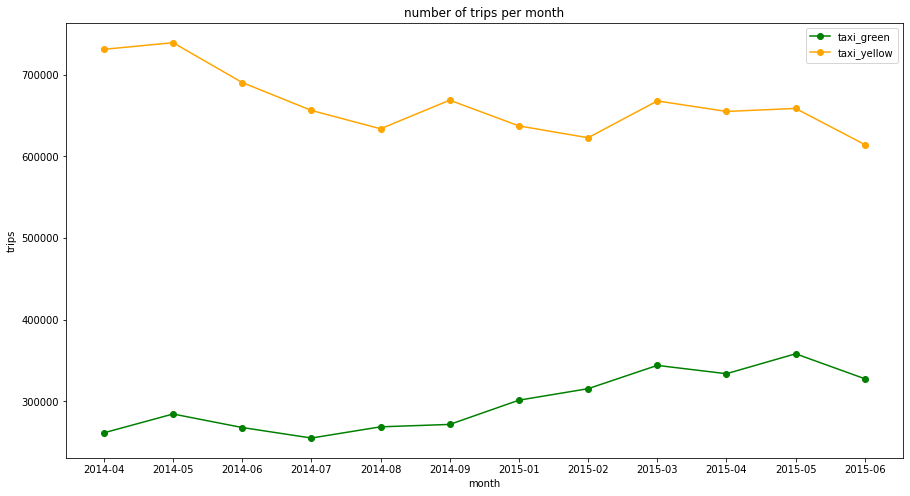

In [45]:
plt.figure(figsize=(15,8))
plt.plot(series_taxi_green, label='taxi_green', marker='o', color='green')
plt.plot(series_taxi_yellow, label='taxi_yellow', marker='o', color='orange')
plt.title('number of trips per month')
plt.ylabel('trips')
plt.xlabel('month')
plt.legend()

#### Number of trips of the two types of taxis per hour of the day

In [ ]:
taxi_green_trips['HOUR'] = taxi_green_trips['pickup_datetime'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour)
taxi_yellow_trips['HOUR'] = taxi_yellow_trips['pickup_datetime'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour)
taxi_green_trips_PER_HOUR = taxi_green_trips.groupby('HOUR')['pickup_datetime'].count()
taxi_yellow_trips_PER_HOUR = taxi_yellow_trips.groupby('HOUR')['pickup_datetime'].count()

<BarContainer object of 24 artists>

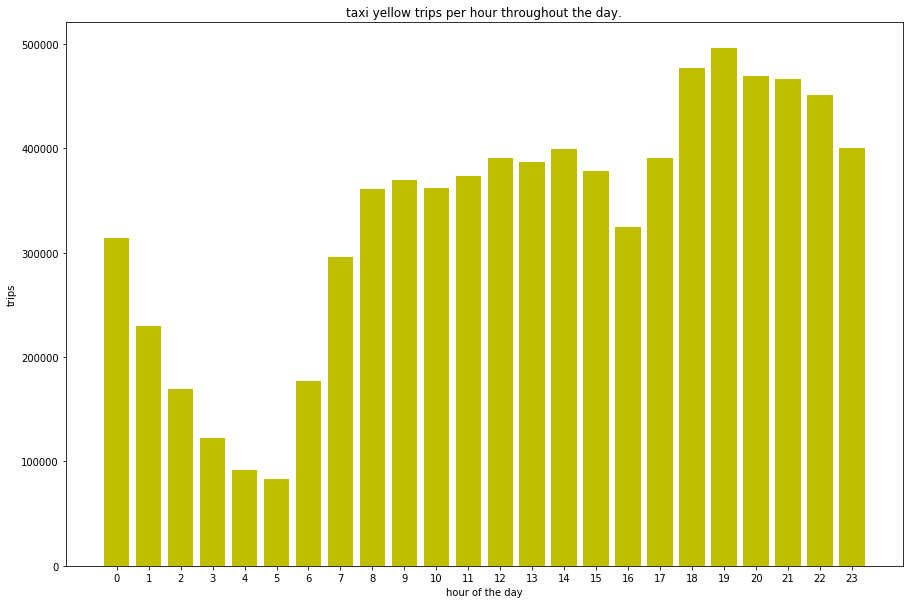

In [46]:
plt.figure(figsize=(15,10))
plt.title('taxi yellow trips per hour throughout the day.')
plt.ylabel('trips')
plt.xlabel('hour of the day')
plt.xticks(taxi_yellow_trips_PER_HOUR.index)
plt.bar(taxi_yellow_trips_PER_HOUR.index, taxi_yellow_trips_PER_HOUR, color='y')

<BarContainer object of 24 artists>

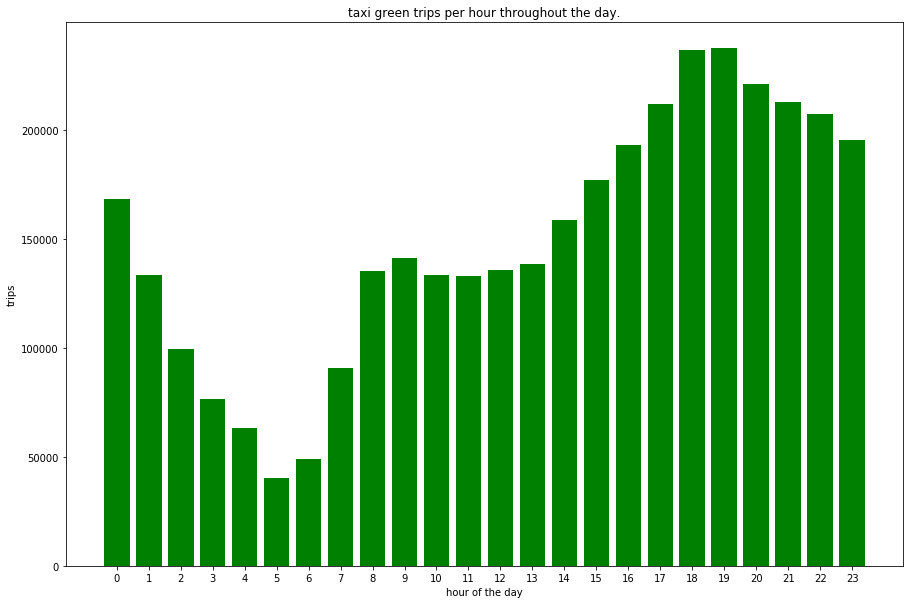

In [47]:
plt.figure(figsize=(15,10))
plt.title('taxi green trips per hour throughout the day.')
plt.ylabel('trips')
plt.xlabel('hour of the day')
plt.xticks(taxi_green_trips_PER_HOUR.index)
plt.bar(taxi_green_trips_PER_HOUR.index, taxi_green_trips_PER_HOUR, color='g')

#### Difference in average trip_distance in taxis

In [48]:
taxi_green_trips[['passenger_count', 'trip_distance', 'total_amount']].mean()

passenger_count     1.404419
trip_distance       2.949620
total_amount       14.782208
dtype: float64

In [49]:
taxi_yellow_trips[['passenger_count', 'trip_distance', 'total_amount']].mean()

passenger_count     1.688382
trip_distance      16.597880
total_amount       15.609972
dtype: float64

### Weather data

In [ ]:
weather = pd.read_csv('Datasets/weather.csv')

#### Correlation of weather factors with Uber trips

In [31]:
#number of trips per day in 2014
uber_trips_2014['pickup_time'] = pd.to_datetime(uber_trips_2014['pickup_datetime'])
uber_trips_2014['dd-mm-yyyy'] = uber_trips_2014['pickup_time'].apply(lambda x: x.strftime('%d-%m-%Y'))
number_uber_trips_2014_day_month_year = uber_trips_2014.groupby('dd-mm-yyyy')['pickup_datetime'].count()

In [32]:
##number of trips per day in 2015
uber_trips_2015['pickup_time'] = pd.to_datetime(uber_trips_2015['pickup_datetime'])
uber_trips_2015['dd-mm-yyyy'] = uber_trips_2015['pickup_time'].apply(lambda x: x.strftime('%d-%m-%Y'))
number_uber_trips_2015_day_month_year = uber_trips_2015.groupby('dd-mm-yyyy')['pickup_datetime'].count()

In [33]:
#number of uber trips per day
series = number_uber_trips_2014_day_month_year.add(number_uber_trips_2015_day_month_year, fill_value=0)

In [34]:
weather['date'] = pd.to_datetime(weather['date'])
weather['dd-mm-yyyy'] = weather['date'].apply(lambda x: x.strftime('%d-%m-%Y'))

In [35]:
df = weather.merge(series, 'left', 'dd-mm-yyyy')
df_weather_trips = df[df['pickup_datetime'].isnull() != True].rename(columns={'pickup_datetime': 'uber_trips'})

In [36]:
#helper function
def string_to_float(x):
    x = x.strip()
    if x != '':
        return float(x)
    return 0

In [38]:
# convert data to numeric
df_weather_trips['precipitation'] = df_weather_trips['precipitation'].apply(lambda x: string_to_float(x))
df_weather_trips['snowfall'] = df_weather_trips['snowfall'].apply(lambda x: string_to_float(x))
df_weather_trips['snow_depth'] = df_weather_trips['snow_depth'].apply(lambda x: string_to_float(x))

In [39]:
def get_correlations_for_uber():
    corr_precipitation = np.corrcoef(df_weather_trips['uber_trips'], df_weather_trips['precipitation'])[0,1]
    corr_avg_temp = np.corrcoef(df_weather_trips['uber_trips'], df_weather_trips['avg_temp'])[0,1]
    corr_snowfall = np.corrcoef(df_weather_trips['uber_trips'], df_weather_trips['snowfall'])[0,1]
    corr_snow_depth = np.corrcoef(df_weather_trips['uber_trips'], df_weather_trips['snow_depth'])[0,1]
    
    print('uber_trips vs precipitation: ', round(corr_precipitation, 2))
    print('uber_trips vs avg_temp: ', round(corr_avg_temp, 2))
    print('uber_trips vs snowfall: ', round(corr_snowfall, 2))
    print('uber_trips vs snow_depth: ', round(corr_snow_depth, 2))
    
get_correlations_for_uber()

uber_trips vs precipitation:  0.01
uber_trips vs avg_temp:  -0.39
uber_trips vs snowfall:  0.11
uber_trips vs snow_depth:  0.26


#### Correlation of weather factors TAXI GREEN

In [40]:
taxi_green_trips['pickup_time'] = pd.to_datetime(taxi_green_trips['pickup_datetime'])
taxi_green_trips['dd-mm-yyyy'] = taxi_green_trips['pickup_time'].apply(lambda x: x.strftime('%d-%m-%Y'))
number_taxi_green_trips_day_month_year = taxi_green_trips.groupby('dd-mm-yyyy')['pickup_datetime'].count()
df = weather.merge(number_taxi_green_trips_day_month_year, 'left', 'dd-mm-yyyy')

df_weather_trips = df[df['pickup_datetime'].isnull() != True].rename(columns={'pickup_datetime': 'taxi_green_trips'})
df_weather_trips['precipitation'] = df_weather_trips['precipitation'].apply(lambda x: string_to_float(x))
df_weather_trips['snowfall'] = df_weather_trips['snowfall'].apply(lambda x: string_to_float(x))
df_weather_trips['snow_depth'] = df_weather_trips['snow_depth'].apply(lambda x: string_to_float(x))

In [41]:
def get_correlations_for_taxi_green():
    corr_precipitation = np.corrcoef(df_weather_trips['taxi_green_trips'], df_weather_trips['precipitation'])[0,1]
    corr_avg_temp = np.corrcoef(df_weather_trips['taxi_green_trips'], df_weather_trips['avg_temp'])[0,1]
    corr_snowfall = np.corrcoef(df_weather_trips['taxi_green_trips'], df_weather_trips['snowfall'])[0,1]
    corr_snow_depth = np.corrcoef(df_weather_trips['taxi_green_trips'], df_weather_trips['snow_depth'])[0,1]
    
    print('taxi_green_trips vs precipitation: ', round(corr_precipitation, 2))
    print('taxi_green_trips vs avg_temp: ', round(corr_avg_temp, 2))
    print('taxi_green_trips vs snowfall: ', round(corr_snowfall, 2))
    print('taxi_green_trips vs snow_depth: ', round(corr_snow_depth, 2))
    
get_correlations_for_taxi_green()

taxi_green_trips vs precipitation:  0.0
taxi_green_trips vs avg_temp:  -0.28
taxi_green_trips vs snowfall:  -0.07
taxi_green_trips vs snow_depth:  0.16


#### Correlation of weather factors TAXI YELLOW

In [42]:
taxi_yellow_trips['pickup_time'] = pd.to_datetime(taxi_yellow_trips['pickup_datetime'])
taxi_yellow_trips['dd-mm-yyyy'] = taxi_yellow_trips['pickup_time'].apply(lambda x: x.strftime('%d-%m-%Y'))
number_taxi_yellow_trips_day_month_year = taxi_yellow_trips.groupby('dd-mm-yyyy')['pickup_datetime'].count()
df = weather.merge(number_taxi_yellow_trips_day_month_year, 'left', 'dd-mm-yyyy')

df_weather_trips = df[df['pickup_datetime'].isnull() != True].rename(columns={'pickup_datetime': 'taxi_yellow_trips'})
df_weather_trips['precipitation'] = df_weather_trips['precipitation'].apply(lambda x: string_to_float(x))
df_weather_trips['snowfall'] = df_weather_trips['snowfall'].apply(lambda x: string_to_float(x))
df_weather_trips['snow_depth'] = df_weather_trips['snow_depth'].apply(lambda x: string_to_float(x))

In [43]:
def get_correlations_for_taxi_yellow():
    corr_precipitation = np.corrcoef(df_weather_trips['taxi_yellow_trips'], df_weather_trips['precipitation'])[0,1]
    corr_avg_temp = np.corrcoef(df_weather_trips['taxi_yellow_trips'], df_weather_trips['avg_temp'])[0,1]
    corr_snowfall = np.corrcoef(df_weather_trips['taxi_yellow_trips'], df_weather_trips['snowfall'])[0,1]
    corr_snow_depth = np.corrcoef(df_weather_trips['taxi_yellow_trips'], df_weather_trips['snow_depth'])[0,1]
    
    print('taxi_yellow_trips vs precipitation: ', round(corr_precipitation, 2))
    print('taxi_yellow_trips vs avg_temp: ', round(corr_avg_temp, 2))
    print('taxi_yellow_trips vs snowfall: ', round(corr_snowfall, 2))
    print('taxi_yellow_trips vs snow_depth: ', round(corr_snow_depth, 2))
    
get_correlations_for_taxi_yellow()

taxi_yellow_trips vs precipitation:  0.01
taxi_yellow_trips vs avg_temp:  -0.08
taxi_yellow_trips vs snowfall:  -0.29
taxi_yellow_trips vs snow_depth:  -0.07


#### Summary correlation

##### Uber  
uber_trips vs precipitation:  0.01  
<font color=red>**uber_trips vs avg_temp:  -0.39**</font>  
uber_trips vs snowfall:  0.11  
uber_trips vs snow_depth:  0.26  

##### Taxi Green  
taxi_green_trips vs precipitation:  0.0  
<font color=red>**taxi_green_trips vs avg_temp:  -0.28**</font>  
taxi_green_trips vs snowfall:  -0.07  
taxi_green_trips vs snow_depth:  0.16  
    
##### Taxi Yellow  
taxi_yellow_trips vs precipitation:  0.01  
taxi_yellow_trips vs avg_temp:  -0.08  
<font color=red>**taxi_yellow_trips vs snowfall:  -0.29**</font>  
taxi_yellow_trips vs snow_depth:  -0.07  


### Demographic Data

In [5]:
#We strat loading the dataset that contains the demographic information about each nta
demographics = pd.read_csv('data/demographics.csv')

#### Let's work with the different ages in the dataset


In [12]:
Agesrange=demographics.loc[:,'under_5_years':'over_65_years'].sum()/demographics["population"].sum()
Agesrange

under_5_years    0.063417
5-9_years        0.057964
10-14_years      0.057358
15-19_years      0.065503
20-24_years      0.078453
25-29_years      0.089225
30-34_years      0.080938
35-39_years      0.071808
40-44_years      0.069311
45-49_years      0.069129
50-54_years      0.066258
55-59_years      0.058210
60-64_years      0.050761
over_65_years    0.121667
dtype: float64

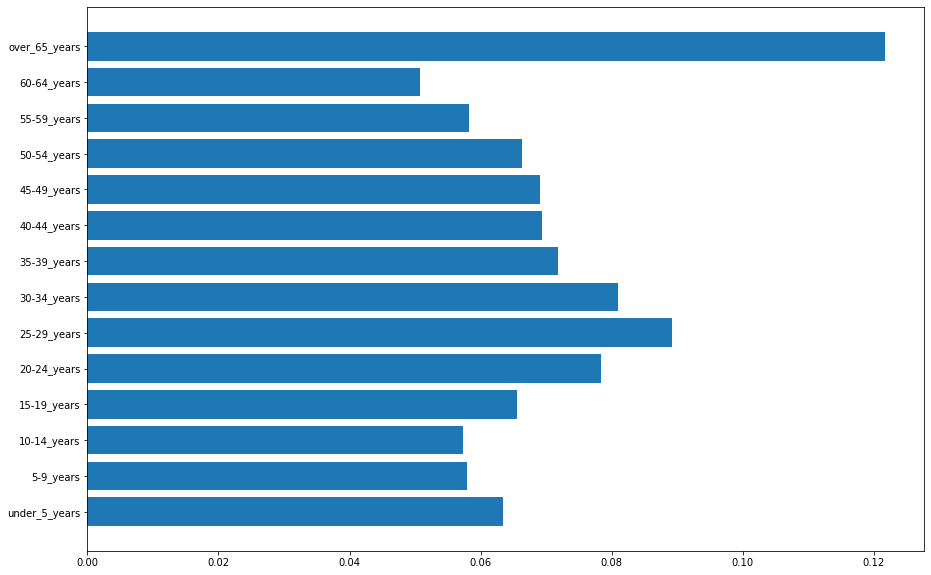

In [13]:
plt.figure(figsize=(15,10))
plt.barh(Agesrange.index,Agesrange.values)
plt.title("Age Range in New York")
plt.show()

In [15]:
#transforming each nta age range from a nominal count into a percentual one

age_range=['under_5_years','5-9_years', '10-14_years', '15-19_years', '20-24_years', '25-29_years',
       '30-34_years', '35-39_years', '40-44_years', '45-49_years',
       '50-54_years', '55-59_years', '60-64_years', 'over_65_years']

#For this transformation we will need to use population, that contains how many people lives in the nta

for col in age_range:
    demographics[col + "%"]=demographics[col]/demographics['population']

In [16]:
#This will show us, how homogeneus is the distribution by age
for col in age_range:
    tempstd=demographics[col + "%"].std()
    tempavg=demographics[col + "%"].mean()
    tempstd2=tempstd/tempavg
    print(col + " Mean " + "{0:.0%}".format(tempavg) + " Std " + "{0:.0%}".format(tempstd) + " Std2 " + "{0:.0%}".format(tempstd2))

under_5_years Mean 6% Std 2% Std2 28%
5-9_years Mean 6% Std 2% Std2 29%
10-14_years Mean 6% Std 2% Std2 31%
15-19_years Mean 7% Std 2% Std2 29%
20-24_years Mean 8% Std 2% Std2 26%
25-29_years Mean 9% Std 3% Std2 34%
30-34_years Mean 8% Std 2% Std2 28%
35-39_years Mean 7% Std 1% Std2 17%
40-44_years Mean 7% Std 1% Std2 11%
45-49_years Mean 7% Std 1% Std2 12%
50-54_years Mean 7% Std 1% Std2 15%
55-59_years Mean 6% Std 1% Std2 17%
60-64_years Mean 5% Std 1% Std2 24%
over_65_years Mean 12% Std 4% Std2 34%


From the last table we can observe that the youngest and the oldest groups are the ones with the biggest deviation, this suggest that the they are more concentrated in some areas than people in the range from 35 to 65 years

#### Understanding the income


For an easer understanding of the data, we are going to transform the income categories to percentual values. The income range was defined for households, so we should do the transformation using this variable

less_than_10,000    0.103311
10000_to_14999      0.062144
15000_to_24999      0.106355
25000_to_34999      0.090372
35000_to_49999      0.116011
50000_to_74999      0.154561
75000_to_99999      0.109527
100000_to_149999    0.126238
150000_to_199999    0.057089
200000_or_more      0.074392
dtype: float64


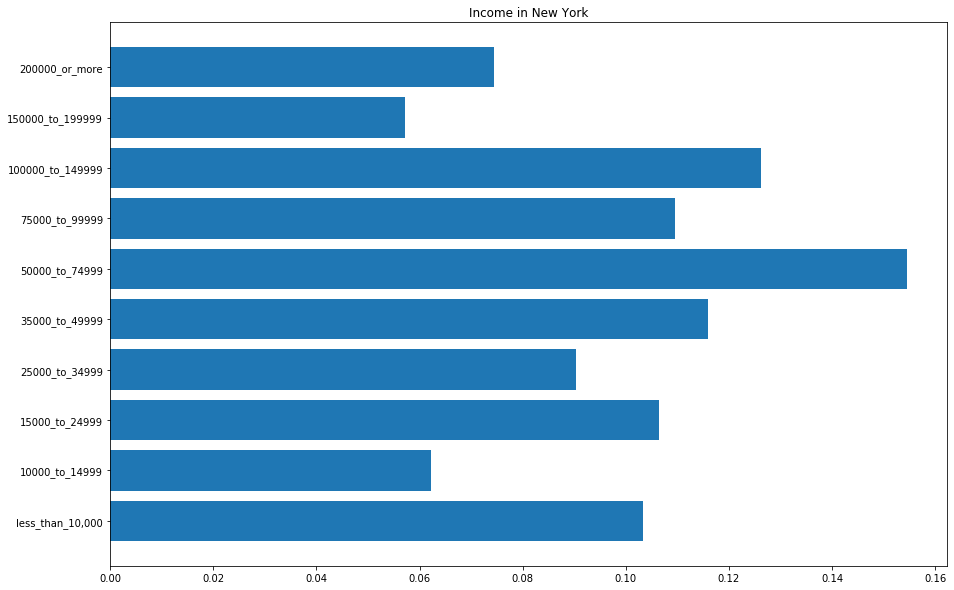

In [31]:
Incomerange=demographics.loc[:,'less_than_10,000':'200000_or_more'].sum()/demographics["households"].sum()
print(Incomerange)
plt.figure(figsize=(15,10))
plt.barh(Incomerange.index,Incomerange.values)
plt.title("Income in New York")
plt.show()

In [19]:
income_range=['less_than_10,000','10000_to_14999', '15000_to_24999', '25000_to_34999', '35000_to_49999',
       '50000_to_74999', '75000_to_99999', '100000_to_149999',
       '150000_to_199999', '200000_or_more']

In [20]:
for col in income_range:
    demographics[col + "%"]=demographics[col]/demographics['households']

In [24]:
demographics.columns

Index(['nta_name', 'borough', 'nta_code', 'population', 'under_5_years',
       '5-9_years', '10-14_years', '15-19_years', '20-24_years', '25-29_years',
       '30-34_years', '35-39_years', '40-44_years', '45-49_years',
       '50-54_years', '55-59_years', '60-64_years', 'over_65_years',
       'median_age', 'people_per_acre', 'households', 'less_than_10,000',
       '10000_to_14999', '15000_to_24999', '25000_to_34999', '35000_to_49999',
       '50000_to_74999', '75000_to_99999', '100000_to_149999',
       '150000_to_199999', '200000_or_more', 'median_income', 'mean_income',
       'under_5_years%', '5-9_years%', '10-14_years%', '15-19_years%',
       '20-24_years%', '25-29_years%', '30-34_years%', '35-39_years%',
       '40-44_years%', '45-49_years%', '50-54_years%', '55-59_years%',
       '60-64_years%', 'over_65_years%', 'less_than_10,000%',
       '10000_to_14999%', '15000_to_24999%', '25000_to_34999%',
       '35000_to_49999%', '50000_to_74999%', '75000_to_99999%',
       '100000_

In [28]:
demographics.loc[0,'less_than_10,000%':'200000_or_more%']

less_than_10,000%    0.0872014
10000_to_14999%      0.0362992
15000_to_24999%      0.0831334
25000_to_34999%        0.08063
35000_to_49999%       0.120997
50000_to_74999%       0.183999
75000_to_99999%       0.120476
100000_to_149999%     0.162929
150000_to_199999%    0.0797956
200000_or_more%      0.0445395
Name: 0, dtype: object

In [30]:
for col in income_range:
    tempstd=demographics[col + "%"].std()
    tempavg=demographics[col + "%"].mean()
    tempstd2=tempstd/tempavg
    print(col + " Mean " + "{0:.0%}".format(tempavg) + " Std " + "{0:.0%}".format(tempstd) + " Std2 " + "{0:.0%}".format(tempstd2))

less_than_10,000 Mean 10% Std 6% Std2 56%
10000_to_14999 Mean 6% Std 3% Std2 54%
15000_to_24999 Mean 11% Std 4% Std2 35%
25000_to_34999 Mean 9% Std 3% Std2 29%
35000_to_49999 Mean 12% Std 3% Std2 24%
50000_to_74999 Mean 16% Std 3% Std2 19%
75000_to_99999 Mean 11% Std 3% Std2 29%
100000_to_149999 Mean 13% Std 5% Std2 41%
150000_to_199999 Mean 6% Std 3% Std2 60%
200000_or_more Mean 6% Std 7% Std2 118%


After reviewing the last table we can observe that those with incomes over 100.000 dollars are concentrated in fewer zones than those with lower incomes. This effect is a lot bigger that the one observed in the age of the communities